# 2. Implementación del modelo

In [9]:
import pandas as pd
import numpy as np
import ast
#Graficar
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#Modelo
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


import warnings
warnings.filterwarnings("ignore")

In [10]:
#Leyendo los datos y convirtiendolos a un data frame
df = pd.read_csv("ds_challenge_apr2021.csv")
pd.set_option("display.max_columns", None)

#Desanidando columna "dispositivos" - Se agregaran nuevas columnas al final
df["dispositivo"] =  df["dispositivo"].map(lambda d : ast.literal_eval(d))
df= df.join(pd.DataFrame(df["dispositivo"].to_dict()).T)

#Quitando dispositivo
df.drop(['dispositivo'], axis=1,inplace=True)

#Añadiendo día de la semana (Solo para ver si influye)
df['fecha'] = pd.to_datetime(df['fecha'])
df['dia_semana'] = df['fecha'].dt.day_name()
df.tail(2)

,ID_USER,genero,monto,fecha,hora,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,model,device_score,os,dia_semana
26973,3999,M,24.182665,2020-01-13,17,NaN,Toluca,Física,40000,56,Aceptada,False,2.418266,0.217644,False,2020,5,.,Monday
26974,3999,M,517.209272,2020-01-03,20,MPago,Toluca,Física,40000,56,En proceso,False,0.000000,5.172093,False,2020,5,ANDROID,Friday


# Preparando la data para el modelo

In [11]:
#Dando valores binarios a fraude
df["fraude"] = np.where(df["fraude"] == True, 1, 0)
df.drop(['fecha'], axis=1, inplace=True) #Realmente no aporta

#Reemplazando nan
df = df.replace(np.nan, "desconocido")

In [14]:
#Creando variables dummies para las variables categoricas
cat_var=['genero','establecimiento','ciudad','tipo_tc','status_txn','is_prime','os','dia_semana']

for var in cat_var:
    catList = 'var'+'_'+var
    catList = pd.get_dummies(df[var], prefix=var)
    df1 = df.join(catList)
    df = df1
    
df_vars = df.columns.values.tolist()
to_keep = [i for i in df_vars if i not in cat_var]
df_final = df[to_keep]
df_final.columns.values

array(['ID_USER', 'monto', 'hora', 'linea_tc', 'interes_tc', 'dcto',
       'cashback', 'fraude', 'model', 'device_score', 'genero_--',
       'genero_F', 'genero_M', 'establecimiento_Abarrotes',
       'establecimiento_Farmacia', 'establecimiento_MPago',
       'establecimiento_Restaurante', 'establecimiento_Super',
       'establecimiento_desconocido', 'ciudad_Guadalajara',
       'ciudad_Merida', 'ciudad_Monterrey', 'ciudad_Toluca',
       'ciudad_desconocido', 'tipo_tc_Física', 'tipo_tc_Virtual',
       'status_txn_Aceptada', 'status_txn_En proceso',
       'status_txn_Rechazada', 'is_prime_False', 'is_prime_True', 'os_%%',
       'os_.', 'os_ANDROID', 'os_WEB', 'dia_semana_Friday',
       'dia_semana_Monday', 'dia_semana_Saturday', 'dia_semana_Sunday',
       'dia_semana_Thursday', 'dia_semana_Tuesday',
       'dia_semana_Wednesday'], dtype=object)

# Balanceando data

In [15]:
#Over-sampling usando SMOTE para balancear
X = df_final.loc[:, df_final.columns != 'fraude'] #Features
y = df_final.loc[:, df_final.columns == 'fraude'] #Target


os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_df_X, os_df_y = os.fit_sample(X_train, y_train)
os_df_X = pd.DataFrame(data = os_df_X, columns = columns )
os_df_y= pd.DataFrame(data = os_df_y, columns = ['fraude'])

#Revisando que la info esté balanceada
print("Tamaño de la data oversampled ",len(os_df_X))
print("Númbero de transacciones verídicas oversampled data",len(os_df_y[os_df_y['fraude']==0]))
print("Number de transacciones fraudulentas",len(os_df_y[os_df_y['fraude']==1]))

Tamaño de la data oversampled  36648
Númbero de transacciones verídicas oversampled data 18324
Number de transacciones fraudulentas 18324


# Escogiendo las mejores características (features)

In [16]:
# A través de Recursive Feature Elimination (RFE) se escogen las mejores características
df_final_vars = df_final.columns.values.tolist()
y = ['fraude']
X = [i for i in df_final_vars if i not in y]

logreg = LogisticRegression()

rfe = RFE(logreg, n_features_to_select=20)
rfe = rfe.fit(os_df_X, os_df_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)
print(os_df_X.columns[rfe.support_])

[False False False False False False False False False False False False
  True  True  True  True  True  True False False  True  True  True False
 False False False False False False  True  True  True  True  True  True
  True  True  True  True  True]
[21 19 17 22 18 20 16 15 14  9 11 10  1  1  1  1  1  1  2  3  1  1  1  5
  4  8  7  6 13 12  1  1  1  1  1  1  1  1  1  1  1]
Index(['establecimiento_Abarrotes', 'establecimiento_Farmacia',
       'establecimiento_MPago', 'establecimiento_Restaurante',
       'establecimiento_Super', 'establecimiento_desconocido',
       'ciudad_Monterrey', 'ciudad_Toluca', 'ciudad_desconocido', 'os_%%',
       'os_.', 'os_ANDROID', 'os_WEB', 'dia_semana_Friday',
       'dia_semana_Monday', 'dia_semana_Saturday', 'dia_semana_Sunday',
       'dia_semana_Thursday', 'dia_semana_Tuesday', 'dia_semana_Wednesday'],
      dtype='object')


In [19]:
#Ya que se eligieron las columnas
cols=['establecimiento_Abarrotes', 'establecimiento_Farmacia',
       'establecimiento_MPago', 'establecimiento_Restaurante',
       'establecimiento_Super', 'establecimiento_desconocido',
       'ciudad_Monterrey', 'ciudad_Toluca', 'ciudad_desconocido', 'os_%%',
       'os_.', 'os_ANDROID', 'os_WEB', 'dia_semana_Friday',
       'dia_semana_Monday', 'dia_semana_Saturday', 'dia_semana_Sunday',
       'dia_semana_Thursday', 'dia_semana_Tuesday', 'dia_semana_Wednesday'] 
X = os_df_X[cols]
y = os_df_y['fraude']

# Implementando Modelo

In [20]:
#Revisando features elegidas
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.515629
         Iterations 6
                               Results: Logit
Model:                   Logit               Pseudo R-squared:    0.256     
Dependent Variable:      fraude              AIC:                 37833.5454
Date:                    2022-05-19 18:10    BIC:                 38003.7277
No. Observations:        36648               Log-Likelihood:      -18897.   
Df Model:                19                  LL-Null:             -25402.   
Df Residuals:            36628               LLR p-value:         0.0000    
Converged:               1.0000              Scale:               1.0000    
No. Iterations:          6.0000                                             
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
estab

El p-value es alto para "establecimiento_desconocido","ciudad_Toluca ", os_%%","os_ANDROID", por lo que se quitarán estás columna

In [34]:
cols=['establecimiento_Abarrotes', 'establecimiento_Farmacia',
       'establecimiento_MPago', 'establecimiento_Restaurante',
       'establecimiento_Super',
       'ciudad_Monterrey',  'ciudad_desconocido',
        'os_WEB', 'dia_semana_Friday',
       'dia_semana_Monday', 'dia_semana_Saturday', 'dia_semana_Sunday',
       'dia_semana_Thursday', 'dia_semana_Tuesday', 'dia_semana_Wednesday'] 
X = os_df_X[cols]
y = os_df_y['fraude']

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.515871
         Iterations 6
                               Results: Logit
Model:                   Logit               Pseudo R-squared:    0.256     
Dependent Variable:      fraude              AIC:                 37841.2920
Date:                    2022-05-19 18:13    BIC:                 37968.9287
No. Observations:        36648               Log-Likelihood:      -18906.   
Df Model:                14                  LL-Null:             -25402.   
Df Residuals:            36633               LLR p-value:         0.0000    
Converged:               1.0000              Scale:               1.0000    
No. Iterations:          6.0000                                             
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
estab

In [35]:
#Modelo de regresión logística
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [36]:
y_pred = logreg.predict(X_test)
print('Accuracy del modelo de regresión logistica: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy del modelo de regresión logistica: 0.92


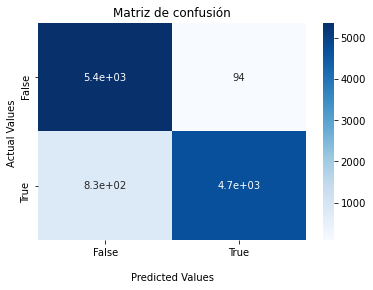

[[5358   94]
 [ 828 4715]]


In [37]:
#Matriz de confusión
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Matriz de confusión');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()
print(cf_matrix)

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      5452
           1       0.98      0.85      0.91      5543

    accuracy                           0.92     10995
   macro avg       0.92      0.92      0.92     10995
weighted avg       0.92      0.92      0.92     10995



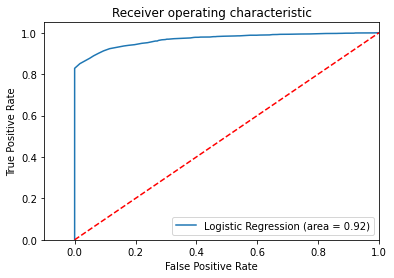

In [39]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()